In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_csv('../data/processed/marketing_final_encoded.csv')

In [15]:
X = df.drop('Response', axis=1)
y = df['Response']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg.fit(X_train, y_train)

c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000)

In [18]:
y_pred = log_reg.predict(X_test)

In [19]:
y_prob = log_reg.predict_proba(X_test)[:, 1]

In [20]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print it in plain format
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[295  86]
 [ 22  45]]


In [21]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.77      0.85       381
           1       0.34      0.67      0.45        67

    accuracy                           0.76       448
   macro avg       0.64      0.72      0.65       448
weighted avg       0.84      0.76      0.79       448



In [22]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.3f}")

ROC-AUC Score: 0.824


RANDOM FOREST CLASSIFIER

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Initialize the model
rf = RandomForestClassifier(random_state=42, class_weight='balanced')  # Handles imbalance


In [24]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [25]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

In [26]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# Classification Report
print(classification_report(y_test, y_pred_rf, digits=3))

# ROC-AUC
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"ROC-AUC Score: {roc_auc_rf:.3f}")

Confusion Matrix:
[[376   5]
 [ 46  21]]
              precision    recall  f1-score   support

           0      0.891     0.987     0.936       381
           1      0.808     0.313     0.452        67

    accuracy                          0.886       448
   macro avg      0.849     0.650     0.694       448
weighted avg      0.879     0.886     0.864       448

ROC-AUC Score: 0.887


Trying hyperparameter tuning

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


In [28]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']  # Ensure class imbalance is handled
}

In [29]:
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [5, 10, None], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='recall', verbose=1)

In [30]:
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [31]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predictions and probabilities
y_pred_best = best_rf.predict(X_test)
y_prob_best = best_rf.predict_proba(X_test)[:, 1]

# Confusion Matrix
print("Confusion Matrix (threshold = 0.5):")
print(confusion_matrix(y_test, y_pred_best))

# Classification Report
print(classification_report(y_test, y_pred_best, digits=3))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob_best)
print(f"ROC-AUC Score: {roc_auc:.3f}")


Confusion Matrix (threshold = 0.5):
[[327  54]
 [ 26  41]]
              precision    recall  f1-score   support

           0      0.926     0.858     0.891       381
           1      0.432     0.612     0.506        67

    accuracy                          0.821       448
   macro avg      0.679     0.735     0.699       448
weighted avg      0.852     0.821     0.833       448

ROC-AUC Score: 0.864


Threshold Improvement

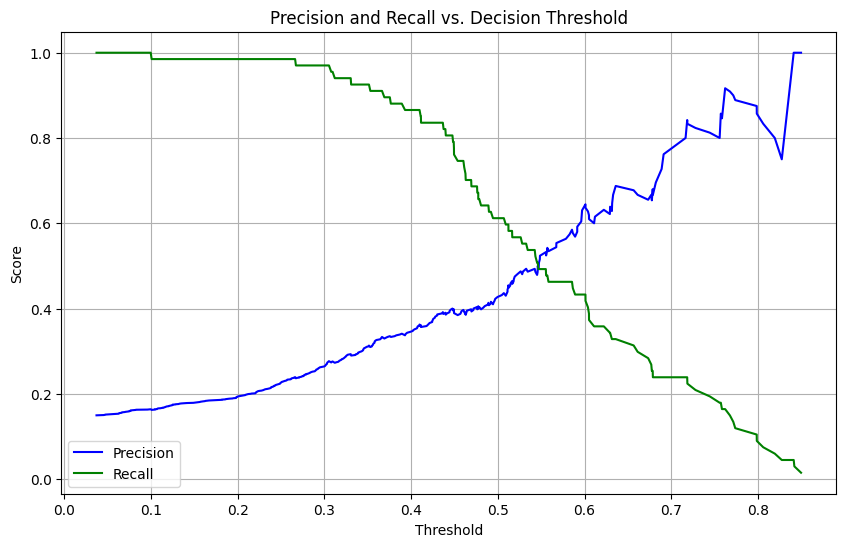

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Get precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_best)

# Plot Precision and Recall against Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='b')
plt.plot(thresholds, recall[:-1], label='Recall', color='g')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Decision Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
import joblib

joblib.dump(best_rf, '../models/best_random_forest_model.pkl')

['../models/best_random_forest_model.pkl']